In [2]:
import skbio as skb
import numpy as np
import pandas as pd
import seaborn as sns
from ecopy import Mantel

from matplotlib import pyplot as plt
import pylab as pl
from skbio import TreeNode
from skbio.stats.distance import mantel
from scipy.stats import linregress
from scipy.spatial.distance import squareform, pdist
from os.path import abspath, join
import os.path
from os import makedirs
from Bio import Phylo
from Bio.Phylo.Consensus import *

In [3]:
output_fig_dir="/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/figures/"
output_mantel_dir="/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/mantel-test-results"

# Import data

## Host tree

In [7]:
tree_dir = abspath('/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged')
host_tree_fp = join(tree_dir, 'host_tree_list.nwk')
host_tree_orig= TreeNode.read(host_tree_fp, format='newick', convert_underscores=False)

host_tips_orig = [x.name for x in host_tree_orig.tips()]

## Metadata

In [15]:
## read in metadata
md_dir = '/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/metadata'
host_md_fp = join(md_dir, 'vert_metadata_8_23.txt')
host_md_orig = pd.read_csv(host_md_fp, sep='\t', encoding='windows-1252')
print(host_md_orig.shape)

## filter metadata based on available value from timetree! 
## Five samples were lost 
## These hosts were missing from timetree
#(Geospiza acutirostris (2 samples), Aspius aspius (2 samples), Cervus canadensis canadensis)
host_md_TT = host_md_orig.loc[(host_md_orig['TimeTree_returned'].isin(host_tips_orig))]

# filter to just these host classes
include_classes = ['Amphibia',
                    'Mammalia',
                    'Aves',
                    'Reptilia',
                  'Hyperoartia',
                  'Actinopterygii']

host_md_TT_classes = host_md_TT.loc[host_md_TT['host_class'].isin(include_classes)]
print(host_md_TT_classes.shape)

host_md_TT_classes_wild= host_md_TT_classes.loc[host_md_TT_classes['captive_wild']=="wild"]
print(host_md_TT_classes_wild.shape)


(671, 30)
(657, 30)
(500, 30)


In [173]:
host_md_orig["diet_category_12"].value_counts()

herbivore                              237
carnivore                              105
omnivore                               104
insectivore                             56
folivore                                46
sanguivore                              30
frugivore                               24
filter_feeder                           21
scavenger                               10
granivore                                9
herbivore, frugivore                     5
omnivore, insectivore                    3
omnivore, gummivore                      2
carnivore, scavenger                     2
omnivore, frugivore                      2
insectivore, granivore                   2
carnivore, omnivore                      2
omnivore, scavenger                      2
frugivore, folivore                      1
aves                                     1
insectivore, frugivore, nectarivore      1
mammals                                  1
insectivore, frugivore, folivore         1
Name: diet_

## bacteria tree

### Insert name of bacteria you want to investigate

In [30]:
bacteria_list_80=["Akkermansia_muciniphila", "Escherichia_coli", 
               "Bacteroides_uniformis", "Bacteroides_fragilis", 
               "Bacteroides_vulgatus", "Clostridium_perfringens",
              "Parabacteroides_distasonis", "Prevotella_copri"]

bacteria_list_65=["Akkermansia_muciniphila", 
                  "Bacteroides_dorei",
               "Bacteroides_fragilis",
                "Bacteroides_uniformis", 
               "Bacteroides_vulgatus", 
                  "Clostridium_perfringens",
                "Escherichia_coli",
               "Lactobacillus_rodentium",
              "Parabacteroides_distasonis", 
                  "Prevotella_copri",
              "Pseudomonas_yamanorum"]

bacteria_list_50=["Akkermansia_muciniphila", 
                  "Bacteroides_dorei",
               "Bacteroides_fragilis", 
               "Bacteroides_thetaiotaomicron", 
                "Bacteroides_uniformis", 
               "Bacteroides_vulgatus", 
                  "Clostridium_perfringens",
                "Escherichia_coli", 
                  "Enterococcus_faecalis",
               "Lactobacillus_rodentium",
              "Parabacteroides_distasonis", 
                  "Prevotella_copri",
              "Pseudomonas_yamanorum"]

bacteria_list_35=["Akkermansia_muciniphila", 
                  "Bacteroides_dorei",
               "Bacteroides_fragilis", 
               "Bacteroides_thetaiotaomicron", 
                "Bacteroides_uniformis", 
               "Bacteroides_vulgatus", 
                  "Clostridium_perfringens",
                  "Collinsella_stercoris",
                "Escherichia_coli", 
                  "Enterococcus_faecalis",
               "Lactobacillus_rodentium",
                "Prevotella_copri",
              "Parabacteroides_distasonis", 
              "Pseudomonas_yamanorum"]

bacteria_list_20=["Akkermansia_muciniphila", 
                  "Alistipes_shahii",
                  "Bacteroides_dorei",
               "Bacteroides_fragilis", 
               "Bacteroides_thetaiotaomicron", 
                "Bacteroides_uniformis", 
               "Bacteroides_vulgatus", 
                  "Clostridium_perfringens",
                  "Collinsella_stercoris",
                "Escherichia_coli", 
                  "Enterococcus_faecalis",
                "Lactobacillus_reuteri",
               "Lactobacillus_rodentium",
                "Prevotella_copri",
              "Parabacteroides_distasonis", 
              "Pseudomonas_yamanorum",
            "Ruthenibacterium_lactatiformans"]

bacteria_list=bacteria_list_80

### Choose parameter to run the algorithm of average mantel test

In [31]:
one_per_sp = True ## One sample per species? 
number_of_iterations=100 ## Number of iteration to create the sample tree given one_per_sp
correlation_coefficient = "spearman"
marker_threshold="80"
sample_group= ""## "" or "_mammallianHost" or "_nonMammallianHost"

In [32]:
mantel_results_dict={}
print( "-----The mantel test for strain trees built with markers threshold at " + marker_threshold +"%-----")
for bacteria in bacteria_list:
    
    print( "\n \n Investigating " + bacteria + ":" )
    host_md=host_md_TT_classes #### !!!!!!!!!!!!!!! Change this metadata according to the md desired
    host_tree=host_tree_orig
    host_tips=host_tips_orig
    
    bacteria_trimmed=bacteria[0]+bacteria[bacteria.find("_"):len(bacteria)]
    tree_dir = abspath('/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/strain-trees-output/output_'+marker_threshold+"_"+bacteria_trimmed + sample_group+"/GAMMA")
    #sample_tree_fp = join(tree_dir, 'strain_tree_GTR_200reps.nwk')
    sample_tree_fp = join(tree_dir, 'RAxML_bestTree.s__'+bacteria+'.StrainPhlAn3.tre')
    try:
        sample_tree= TreeNode.read(sample_tree_fp, format='newick', convert_underscores=False)
    except FileNotFoundError:
        print("No sample tree available")
        continue

    sample_tips = [x.name for x in sample_tree.tips()]

    ## Filter metadata based on the overlapping host tree and sample tree
    md_sampleID_ids = set(host_md['SampleID2'])
    md_timeTree_ids = set(host_md['TimeTree_returned'])


    sample_tips_ids=set(sample_tips)
    host_tips_ids=set(host_tips)

    shared_sample_ids=sample_tips_ids & md_sampleID_ids
    shared_host_ids=host_tips_ids & md_timeTree_ids

        
#     print("Filtering metadata with shared_ids......")
    host_md = host_md.loc[(host_md['SampleID2'].isin(shared_sample_ids))]
    host_md = host_md.loc[(host_md['TimeTree_returned'].isin(shared_host_ids))]
    
    if len(host_md) <=3: 
        print("Too few samples remaining (<=3) aftering filtering by sample name and TimeTree_returned name, skipping...")
        continue
    


    md_sampleID_ids = set(host_md['SampleID2'])
    md_timeTree_ids = set(host_md['TimeTree_returned'])

    # Prune host tree 

    host_tree = host_tree.shear(host_md['TimeTree_returned'])
    host_tips = [x.name for x in host_tree.tips()]

        
    # Prune sample tree randomly multiple times and save into list! 
    sample_tree_list=[]
    if one_per_sp:
        for i in range(0, number_of_iterations):
            ## Find one sample per species randomly
            host_md_subset =  host_md.loc[(host_md['SampleID2'].isin(sample_tips)),].groupby('TimeTree_returned').sample(1).reset_index()
            
            if len(host_md_subset) <=3: 
                break
            
            ## Shear sample tree
            sheared_sample_tree = sample_tree.shear(host_md_subset['SampleID2'])
            ## Add sheared sample tree to list
            sample_tree_list.append(sheared_sample_tree)


    ## Check if number of tips in sample and host tree is the same 
#     print("Same number of nodes between the trees? ==> ")
#     print(len(one_sample_tips) == len(host_tips))
#     one_sample_tips = [x.name for x in sample_tree_list[0].tips()]
    ## Check if the number of sample tree is the same as number of iterations
    if len(sample_tree_list) != number_of_iterations:
        print("Too few samples remaining (<=3) aftering filtering by one sample per species, skipping...")
        continue
    
    ## Calculate patristic distances
    host_patristic_dm = host_tree.tip_tip_distances()

#     sample_tree_list[9]

    sample_patristic_dm_list=[]
    for i in range(0, number_of_iterations):
        sample_patristic_dm = sample_tree_list[i].tip_tip_distances()

        ## acquire sample tip from each tree
        sample_tips = [x.name for x in sample_tree_list[i].tips()]

        ## Change label of sample dm 
        ## get corresponding name of the ids
        rename_df = host_md.loc[host_md['SampleID2'].isin(sample_tips),
                                     ['SampleID2','TimeTree_returned']].set_index('SampleID2')
        rename = [rename_df.loc[x, 'TimeTree_returned'] for x in sample_tips]
        ## Change label of distance matrix 
        sample_patristic_dm.ids = rename

        ## add to host_patristic_dm
        sample_patristic_dm_list.append(sample_patristic_dm)

    ## Test two dm.ids are the same 
#     print("Are the ids of the distance matrices the same? ==> ")
#     print(set(host_patristic_dm.ids) == set(sample_patristic_dm_list[0].ids))

    # Mantel test with results averaged over iterations set
    sum_corr=0
    sum_p=0
    sum_group=0
    for i in range(0, number_of_iterations):
        corr, p, n = mantel(host_patristic_dm, sample_patristic_dm_list[i], method=correlation_coefficient )
        sum_corr+=corr
        sum_p+=p
        sum_group+=n
    print("The average correlation, p values over "+ str(number_of_iterations) + " iterations are:")
    aver_corr=sum_corr/number_of_iterations
    aver_p=sum_p/number_of_iterations
    aver_group=sum_group/number_of_iterations

    print("Number of samples\t"+"average "+ correlation_coefficient + " coorelation\t"+"average p-value\t")
    print(str(aver_group)+"\t"+str(aver_corr)+"\t"+str(aver_p))
    
    mantel_results_dict[bacteria] = (round(aver_corr,4), round(aver_p,4), int(aver_group))


-----The mantel test for strain trees built with markers threshold at 80%-----

 
 Investigating Akkermansia_muciniphila:
No sample tree available

 
 Investigating Escherichia_coli:
The average correlation, p values over 100 iterations are:
Number of samples	average spearman coorelation	average p-value	
55.0	0.01983230281069558	0.61469

 
 Investigating Bacteroides_uniformis:
The average correlation, p values over 100 iterations are:
Number of samples	average spearman coorelation	average p-value	
16.0	-0.30783351786354674	0.0484

 
 Investigating Bacteroides_fragilis:
The average correlation, p values over 100 iterations are:
Number of samples	average spearman coorelation	average p-value	
12.0	-0.09701500912088495	0.54253

 
 Investigating Bacteroides_vulgatus:
The average correlation, p values over 100 iterations are:
Number of samples	average spearman coorelation	average p-value	
12.0	0.2834402010305147	0.18407999999999994

 
 Investigating Clostridium_perfringens:
The average corre

### Save the dictionary to directory 

In [33]:
## What does it look like? 
mantel_save_df =  pd.DataFrame.from_dict(mantel_results_dict, orient='index')
mantel_save_df.columns = ['r','p', 'n']
mantel_save_df

,r,p,n
Escherichia_coli,0.0198,0.6147,55
Bacteroides_uniformis,-0.3078,0.0484,16
Bacteroides_fragilis,-0.0970,0.5425,12
Bacteroides_vulgatus,0.2834,0.1841,12
Clostridium_perfringens,-0.1651,0.0620,20
Parabacteroides_distasonis,0.1739,0.4142,11
Prevotella_copri,0.2130,0.1383,12


In [34]:
want_to_save_dict = True

In [35]:
if want_to_save_dict:
    mantel_save_df.to_csv(join(output_mantel_dir, "mantel_patristic"+sample_group +"_"+marker_threshold+"_"+correlation_coefficient+"_"+ str(number_of_iterations)+"repititions_GTRGAMMA.csv"))

# Visualize distance matrices & run mantel iteratively across tree for later ITOL plotting - Taken and modified from Jon Sander's notebooks

### Function to calculate the degree of phylosymbiosis as we go down the tree considering all subtree with more than 3 tips 

In [18]:
def recursive_mantel_host(tree, dm1, dm2, min_size=4, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        label = n.name
        i += 1
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            continue
        # if not, run mantel
        else:
            tips = [t.name for t in n.tips()]
            dm1_s = dm1.filter(tips)
            dm2_s = dm2.filter(tips)
            corr, p, _ = mantel(dm1_s, dm2_s, **kwargs)
            node_dict[n.name] = (corr, p)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return(node_dict)

### Function to calculate the degree tree of phylosymbiosis as we go down an unsubsetted sample tree considering all subtree with more than 3 tips after 

In [19]:
def recursive_mantel_sample(tree, df, col_groupby, col_sampleID, dm1, min_size=3, **kwargs):
    i = 0
    nodes = tree.count(tips=True) * 2 - 1
    tree.assign_ids()
    node_dict = {}
    for n in tree.postorder():
        i += 1 ## Counter
        label = n.name
        
        # see if you're below minimum clade size
        if n.count(tips=True) < min_size:
            print("skipped this node because of less than 3 leaves!")
            print(n.name)
            print("\n")
            continue
        # if not, run mantel
        else:
            
            ## Loop through subtree and put leaves into a list
            sample_tips = [t.name for t in n.tips()]
            print("Checking out this node")
            print(n.name)

            ## Subset the df based on sample_ids of subtree and random sampling per species 
            df_subset = df.loc[(df[col_sampleID].isin(sample_tips)),].groupby(col_groupby).sample().reset_index()
            print(df_subset['species_id'])
            if len(df_subset) >= 3: ## length of the dimension at least 3 by 3
                print("This node made it!")
                print("\n")
                
                ## Subset the host distance matrix directly 
                dm1_s = dm1.filter(df_subset[col_groupby])

                ## Subset the host tree and the sample tree 
                subtree=tree.shear(df_subset[col_sampleID])
                ## Change tip name of subtree 
                dm2_s = subtree.tip_tip_distances()

                rename_ids = tuple(df_subset.loc[df_subset[col_sampleID]==x.name, col_groupby].values[0] for x in subtree.tips())


                # ## Change label of sample distance matrix 
                dm2_s.ids = list(rename_ids)

                corr, p, _ = mantel(dm1_s, dm2_s, **kwargs)
                node_dict[n.name] = (corr, p)
    
        pct = (i / nodes)
        
        if np.round(pct * 100) % 10 == 0:
            print(pct)
    return node_dict

### Function to plot corresponding distances of two distance matrices

In [20]:
def node_values(mantel_df, bacteria, tree_dm, dist_dm, ax1):
    ## Getting the correlation and p value of mantel test averaaged over 100 iterations 
    r=mantel_df.loc[bacteria,"r"]
    p=mantel_df.loc[bacteria,"p"]
    
    pats = tree_dm
    dsts = dist_dm
    
    x = pats.to_series()
    y = dsts.to_series()
    

    slope, _, _, _, _ = linregress(x, y)
    
    plot = sns.regplot('x',
                      'y',
                      pd.DataFrame({'x': x, 'y': y}).reset_index(),
                      scatter_kws={'alpha':0.1},
                      ax= ax1)
    plt.ylim(0, 1.0)
    plt.xlim(0, max(x)+20)

    print(("r: {r}\n"
       "p: {p}\n"
       "m: {m:8.7f}\n").format(r=r, p=p, m=slope))
    return plot, slope, r, p 

# Choose the species and at what marker threshold you want to invetigate! 
### Filter sample tree to one sample per species 

In [175]:
#### Change these values according the type of bacteria you want to investigate, the correlation used, as well as the subset of samples 
bacteria="Bacteroides_vulgatus"
correlation_type="spearman" ## spearman or pearson
category="" ## Choices are "" , "_mammallianHost", "_nonMammallianHost"
marker_threshold="20"
number_of_iterations=100


In [176]:
bacteria_trimmed=bacteria[0]+bacteria[bacteria.find("_"):len(bacteria)]
tree_dir = abspath('/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/strain-trees-output/output_'+marker_threshold+"_"+bacteria_trimmed+category+"/GAMMA/")
#sample_tree_fp = join(tree_dir, 'strain_tree_GTR_200reps.nwk')
sample_tree_node_name_fp = join(tree_dir, 'RAxML_bestTree.s__'+bacteria+'.StrainPhlAn3.node.tre')
try:
    if os.path.exists(sample_tree_node_name_fp):
        ## Set the sample tree
        sample_tree= TreeNode.read(sample_tree_node_name_fp, format='newick', convert_underscores=False)
    else:
        ## Create the tree with node 
        sample_tree_fp = join(tree_dir, 'RAxML_bestTree.s__'+bacteria+'.StrainPhlAn3.tre')
        sample_tree_noNode= TreeNode.read(sample_tree_fp, format='newick', convert_underscores=False)
       
        count=1
        ## Set the nodes on the tree using non_tip()
        for n in sample_tree_noNode.postorder():
            if n.count(tips=True) > 1:
                if n.is_root():
                    n.name = "root"
                    continue
                n.name = "node"+str(count)
                count+=1
                

        sample_tree = sample_tree_noNode.copy() ## Set sample_tree to new tree with nodes
        sample_tree.write(sample_tree_node_name_fp)
        
except FileNotFoundError:
    print("No sample tree available")

## Sample tree mantel node calculation

In [177]:
dm_host=host_tree_orig.tip_tip_distances()
sample_node_dict=recursive_mantel_sample(sample_tree,host_md_orig,"TimeTree_returned","SampleID2",dm_host)

skipped this node because of less than 3 leaves!
Eudromia-elegans_S_S_Temp_D706-AK1680_filtered_r1r2combined


skipped this node because of less than 3 leaves!
Pteromys-volans_S_S_Temp_D707-AK1545_filtered_r1r2combined


skipped this node because of less than 3 leaves!
node1


skipped this node because of less than 3 leaves!
Eudromia-elegans_S_S_Temp_D710-AK1682_filtered_r1r2combined


skipped this node because of less than 3 leaves!
Choloepus-hoffmanni_Song51_25173_host_filtered_r1r2combined


skipped this node because of less than 3 leaves!
Rhea-americana_Song53_24102_host_filtered_r1r2combined


skipped this node because of less than 3 leaves!
Trachypithecus-delacouri_SAMEA6809447.ebi_filtered_r1r2combined_sampleCombined


skipped this node because of less than 3 leaves!
node2


skipped this node because of less than 3 leaves!
Lemur-catta_Song51_24592_host_filtered_r1r2combined


skipped this node because of less than 3 leaves!
Gorilla-gorilla_Song51_25120_host_filtered_r1r2combined

0.7011494252873564
Checking out this node
node28
0           domestic_goose.3
1                    fossa.1
2              fallow_deer.1
3    northern_house-martin.1
4             domestic_cat.2
5           dwarf_mongoose.2
6                    human.1
7         pygmy_slow_loris.2
8                 kinkajou.1
9        southern_tamandua.1
Name: species_id, dtype: object
This node made it!


skipped this node because of less than 3 leaves!
Homo-sapiens_SAMEA6809425.ebi_filtered_r1r2combined_sampleCombined


Checking out this node
node29
0           domestic_goose.3
1                    fossa.1
2              fallow_deer.1
3    northern_house-martin.1
4             domestic_cat.2
5           dwarf_mongoose.2
6                    human.1
7         pygmy_slow_loris.2
8                 kinkajou.1
9        southern_tamandua.1
Name: species_id, dtype: object
This node made it!


skipped this node because of less than 3 leaves!
Sarcoramphus-papa_S_S_Temp_D705-AK1682_filtered_r1r2combined


skipp

In [178]:
sample_node_dict

{'node4': (0.19964123884621948, 0.383),
 'node5': (0.2598379671947494, 0.584),
 'node6': (0.017072521383876257, 0.952),
 'node8': (0.30592647175696214, 0.009),
 'node9': (0.3303494051506864, 0.033),
 'node12': (-0.9999338583898293, 0.337),
 'node13': (-0.44473704364652555, 0.344),
 'node14': (0.3975285882213688, 0.021),
 'node15': (0.39703693385209055, 0.018),
 'node16': (0.41670159286459096, 0.014),
 'node20': (-0.32323815643556464, 1.0),
 'node21': (-0.3690244367572667, 0.403),
 'node22': (-0.11341385028158926, 0.888),
 'node27': (0.14333202371659573, 0.565),
 'node28': (0.16873555066680854, 0.416),
 'node29': (0.16873555066680854, 0.412),
 'node31': (0.056145452193303, 0.853),
 'node32': (0.10225100640422312, 0.721),
 'node33': (0.10686603928813611, 0.639),
 'node35': (0.23603978877163145, 0.23),
 'node37': (-0.9933300896766428, 0.334),
 'node38': (-0.9991267042626484, 0.384),
 'node39': (0.18337669332681047, 0.338),
 'node40': (0.08606921959419757, 0.629),
 'node41': (0.12197312406

### Write nodes associated with full sample tree to file for visualizaation on subsequent ITOL tree 
##### Remember the sample tree with annotated nodes itself have already been created and saved

In [179]:
want_to_save_file = True

In [180]:
if want_to_save_file:
    node_df =  pd.DataFrame.from_dict(sample_node_dict, orient='index')
    node_df.columns = ['r','p']
    node_df.to_csv(join(tree_dir, "mantel_patristic_sampleTreeNodes_" +marker_threshold+"_"+correlation_type+ category +".csv"))

## Host tree mantel node calculation
### Subset metadata to only those samples in sample tree then subset to one per species

In [338]:
sample_tips = [x.name for x in sample_tree.tips()] ## find nodes
host_md_bacteria=host_md_orig.loc[(host_md_orig['SampleID2'].isin(sample_tips)),] ## subset metadata

In [339]:
one_per_species = True

In [340]:
if one_per_species: 
    host_md_bacteria_1s = host_md_bacteria.loc[(host_md_bacteria['SampleID2'].isin(sample_tips)),].groupby('TimeTree_returned').first().reset_index()
    host_md_bacteria = host_md_bacteria_1s ## resave the image for clarity sake

### Prune sample and host tree with new subset  then convert to distance matrices 

In [341]:
sheared_sample_tree = sample_tree.shear(host_md_bacteria['SampleID2'])
sheared_host_tree = host_tree_orig.shear(host_md_bacteria['TimeTree_returned'])

In [342]:
host_patristic_dm = sheared_host_tree.tip_tip_distances() ## create host dm
bacteria_patristic_dm =sheared_sample_tree.tip_tip_distances() ## Create bacteria dm 

## Change tip names of bacteria_patristic_dm 
# acquire sample tip from each tree
sample_tips = [x.name for x in sheared_sample_tree.tips()]

# ## Change label of sample dm 
# ## get corresponding name of the ids
rename_df = host_md_bacteria.loc[host_md_bacteria['SampleID2'].isin(sample_tips),
                             ['SampleID2','TimeTree_returned']].set_index('SampleID2')
rename_ids = [rename_df.loc[x, 'TimeTree_returned'] for x in sample_tips]
print(rename_ids)
print(type(rename_ids))

print(bacteria_patristic_dm.ids)
print(type(bacteria_patristic_dm.ids))

# ## Change label of distance matrix 
bacteria_patristic_dm.ids = tuple(rename_ids)

['Choloepus_hoffmanni', 'Eudromia_elegans', 'Lepus_europaeus', 'Anser_anser', 'Nycticebus_pygmaeus', 'Delichon_urbicum', 'Helogale_parvula', 'Sarcoramphus_papa', 'Potos_flavus', 'Homo_sapiens', 'Tamandua_tetradactyla', 'Dama_dama', 'Suricata_suricatta', 'Colobus_guereza', 'Vulpes_vulpes', 'Mungos_mungo', 'Nyctereutes_procyonoides', 'Tolypeutes_matacus', 'Callosciurus_prevostii']
<class 'list'>
('Choloepus-hoffmanni_Song51_25173_host_filtered_r1r2combined', 'Eudromia-elegans_S_S_Temp_D710-AK1682_filtered_r1r2combined', 'Lepus-europaeus_SAMEA6809601.ebi_filtered_r1r2combined_sampleCombined', 'Anser-anser_SAMEA6809432.ebi_filtered_r1r2combined_sampleCombined', 'Nycticebus-pygmaeus_SAMEA6809443.ebi_filtered_r1r2combined_sampleCombined', 'Delichon-urbicum_SAMEA6809453.ebi_filtered_r1r2combined_sampleCombined', 'Helogale-parvula_S_S_Temp_D704-AK1544_filtered_r1r2combined', 'Sarcoramphus-papa_S_S_Temp_D705-AK1780_filtered_r1r2combined', 'Potos-flavus_SAMEA6809525.ebi_filtered_r1r2combined_sam

In [343]:
# assign internal node names, non-integer (e.g 268 --> node 268)
sheared_host_tree.assign_ids()

for n in sheared_host_tree.postorder():
    if n.is_tip():
        continue
    elif n.name[0].isdigit(): 
        n.name = "node%s" % n.name

In [344]:
node_dict = recursive_mantel_host( sheared_host_tree, host_patristic_dm, bacteria_patristic_dm, method=correlation_type)

1.0


In [345]:
node_dict


{'node227': (0.753702346348183, 0.227),
 'node523': (-0.03692744729379982, 0.949),
 'node312': (0.0537923237370915, 0.755),
 'node397': (0.052847951887584725, 0.91),
 'node517': (0.16402458687611404, 0.313),
 'node527': (0.45793550804619343, 0.007),
 'node526': (0.3073903085717003, 0.032)}

### Write nodes associated with host tree as well as sheared host tree to file for visualization on subsequent ITOL tree 

In [346]:
want_to_save_file = True

In [347]:
if want_to_save_file:
    ## Save the host tree
    sheared_host_tree.write(join(tree_dir,'sheared_host_tree' + category +".tre"), format='newick')
    
    ## Save the nodes 
    node_df =  pd.DataFrame.from_dict(node_dict, orient='index')
    node_df.columns = ['r','p']
    node_df.to_csv(join(tree_dir, "mantel_patristic_hostTreeNodes_" +marker_threshold+"_"+correlation_type+ category +".csv"))

### Plot linear relationship of the dm of entire tree; present mantel test results on the same plot
#### Extract stored value of mantel test over 100 iteration 

In [348]:
file_name="mantel_patristic"+category+"_"+marker_threshold+"_" +correlation_type+"_"+ str(number_of_iterations) +"repititions_GTRGAMMA.csv"
print(file_name)
mantel_df = pd.read_csv(join(output_mantel_dir, file_name),index_col=0)
mantel_df

mantel_patristic_50_spearman_100repititions_GTRGAMMA.csv


,r,p,n
Akkermansia_muciniphila,0.2531,0.0220,18
Bacteroides_dorei,0.0054,0.8620,15
Bacteroides_fragilis,0.0589,0.7248,18
Bacteroides_thetaiotaomicron,0.3552,0.0109,14
Bacteroides_uniformis,-0.0062,0.9313,25
Bacteroides_vulgatus,0.3369,0.0287,19
Clostridium_perfringens,0.1587,0.0220,35
Escherichia_coli,-0.0380,0.3770,68
Enterococcus_faecalis,-0.0125,0.9155,15
Parabacteroides_distasonis,0.2162,0.2721,13


In [349]:
## Checking if the two dm is the same
host_patristic_dm.shape == bacteria_patristic_dm.shape

True

#### Plot distance matrixes

/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


r: -0.038
p: 0.377
m: 0.0000272



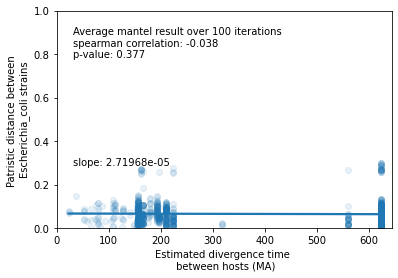

In [278]:
fig, ax1 = plt.subplots(1,1)
# node_values(tips, host_tree_subset, node_df_spearson, patristic_dm, dm_subset)
ax1, m, r, p = node_values(mantel_df, bacteria, host_patristic_dm, bacteria_patristic_dm,ax1)
ax1.set_xlabel("Estimated divergence time \n between hosts (MA)")
ax1.set_ylabel("Patristic distance between \n" + bacteria+" strains")
ax1.text(0.05,0.85,'Average mantel result over '+str(number_of_iterations)+' iterations\n'+correlation_type+' correlation: ' + str(round(r,3)) + "\np-value: " + str(round(p,3)),horizontalalignment='left',
     verticalalignment='center', transform = ax1.transAxes)
ax1.text(0.05,0.30,"slope: " + str(round(m,10)),horizontalalignment='left',
     verticalalignment='center', transform = ax1.transAxes)

plt.savefig(output_fig_dir+"phylosymbiosis_"+marker_threshold+"_"+bacteria+"_"+correlation_type+"_"+str(number_of_iterations)+"repititions.png",dpi=900, bbox_inches="tight")
fig.show()

# Create itol tree color file and annotations taken from Jon Sander's notebook

### Choose which tree & nodes we are interested in. Host or sample/bacteria tree? 

In [181]:
## Choose which tree ==> "host" for host tree, "bacteria" for sample tree 
    ## Remember: we are more interested in the subsetted sample tree than the subsetted sample tree 
    ## used to calculate the phylosymbiosis level for the host tree
decision = "bacteria"
save_sample_tree = True
if decision == "host": 
    ## Get corresponding tree
    tree_interested =  TreeNode.read(join(tree_dir,'sheared_host_tree' + category +".tre"), format='newick', convert_underscores=False)
    ## Get tree tips 
    tree_tips = [x.name for x in tree_interested.tips()]
    ## Get node and associated p and r values 
    node_df = pd.read_csv(join(tree_dir, "mantel_patristic_hostTreeNodes_" +marker_threshold+"_"+correlation_type+ category +".csv"), index_col=0)
    ## Get annotation for saving
    annotation = "hostTree_"
    ## Save associated dataframe
    subset_md=host_md_bacteria
    
elif decision == "bacteria":
    tree_sampleID2 = TreeNode.read(join(tree_dir, 'RAxML_bestTree.s__'+bacteria+'.StrainPhlAn3.node.tre'),format='newick', convert_underscores=False)
    tree_tips_sampleID2 = [x.name for x in tree_sampleID2.tips()]
    subset_md = host_md_orig.loc[host_md_orig['SampleID2'].isin(tree_tips_sampleID2),]
    
    # Change leaf name to corresponding TimeTree_returned value
    for n in tree_sampleID2.tips():
        if n.name != bacteria and n.name != "Escherichia_coli_o157_h7":
            n.name = str(subset_md.loc[subset_md['SampleID2'] == n.name, 'species_id'].values[0])
    
    if save_sample_tree: 
        tree_sampleID2.write(join(tree_dir, 'RAxML_bestTree.s__'+bacteria+'.StrainPhlAn3.node_leafName.tre'))
    
    tree_interested=tree_sampleID2
    tree_tips=[x.name for x in tree_interested.tips()]
    
    node_df=pd.read_csv(join(tree_dir, "mantel_patristic_sampleTreeNodes_" +marker_threshold+"_"+correlation_type+ category +".csv"), index_col=0)
    annotation = "sampleTree_"


### Phylosymbiosis color bar

In [351]:
itol_annotation_dir=tree_dir+"/itol"
makedirs(itol_annotation_dir, exist_ok=True)

In [352]:
node_df['r'].max()

0.9817453545482834

In [353]:
import matplotlib as mpl

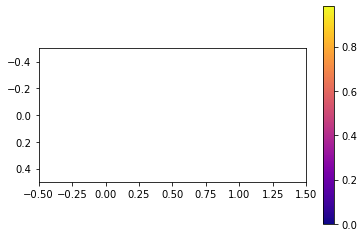

In [354]:
cmax = node_df['r'].max()
img = plt.imshow(np.array([[0,cmax]]), cmap=mpl.cm.plasma)
img.set_visible(False)

plt.colorbar(orientation="vertical")

In [355]:
def colorbar(fp,
             cmax=1,
             size=(4,.7)):
    a = np.array([[0,cmax]])
    pl.figure(figsize=size)
    img = pl.imshow(a, cmap=mpl.cm.plasma)
    pl.gca().set_visible(False)
    cax = pl.axes([0.1, 0.4, 0.8, 0.5])
    pl.colorbar(orientation='horizontal', cax=cax)
    pl.savefig(fp)

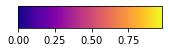

In [356]:
colorbar(join(itol_annotation_dir, annotation+"mantel_"+ correlation_type +"_itol-r_colorbar.pdf"),
         cmax=node_df['r'].max(),
         size=(2.5,.6))

### Phylosymbiosis color gradient

In [357]:
def get_colors(vals, col, cmap=mpl.cm.plasma):
    norm = mpl.colors.Normalize(vmin=0, vmax=np.max(vals))
    
    colors = []
    
    for i in vals:
        rgb = mpl.cm.ScalarMappable(norm=norm,
                                    cmap=cmap).to_rgba(i)
        hex_val = mpl.colors.rgb2hex(rgb)
        colors.append(hex_val)

    return(colors)

def write_itol_colors(node_df, col, fp, label='branch_colors'):
    out = ('DATASET_STYLE\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #ffff00\n\n'
           'DATASET_LABEL %s\n\n'
           'DATA\n'
           '#NODE_ID TYPE COLOR LABEL_OR_STYLE SIZE_FACTOR\n' % label)

    for i, row in node_df.iterrows():
        out += '{0} branch node {1} 2 normal\n'.format(i, row[col])

    with open(fp, 'w') as f:
        f.write(out)

In [360]:
node_df['r_color'] = get_colors(node_df['r'], col='r')
node_df

,r,p,r_color
node4,-0.315813,1.000,#0d0887
node5,0.669152,0.069,#ef7e50
node6,0.722748,0.031,#f79044
node9,-0.341436,1.000,#0d0887
node10,-0.374155,0.418,#0d0887
node14,-0.295536,1.000,#0d0887
node15,-0.147550,0.466,#0d0887
node17,0.981745,0.330,#f0f921
node18,-0.034977,0.880,#0d0887
node19,0.033181,0.845,#220690


In [359]:
write_itol_colors(node_df, 
                  'r_color', 
                  join(itol_annotation_dir, annotation+'mantel_patristic_' + correlation_type+ '_itol-r_colors.txt'),
                  label=correlation_type+'_r')

### Category highlighting

In [289]:
def write_clade_highlights(md_df, tree, tax_col, tree_col, fp,
                           label='category_highlights',
                           colors=None, alpha=0.4, cmap=mpl.cm.Set3):
    out = ('DATASET_COLORSTRIP\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #b2df8a\n\n'
           'DATASET_LABEL %s\n\n'% label)
    
    taxa = md_df[tax_col].unique()
    
    if colors is None:
        clist = cmap(range(len(taxa)), alpha=alpha)
        rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
                                          int(x[1]*255),
                                          int(x[2]*255),
                                          x[3]) for x in clist]
        colors = {x: rgblist[i] for i, x in enumerate(taxa)}
    else:
        colors = { clade: colors[clade] for clade in taxa}
    
    legend_shapes = ' '.join(['1']*len(taxa))
    legend_colors = ''
    legend_labels = ''
    
    ## Add annotations you may want with regards to this annotation  
    out += ('SHOW_INTERNAL 1\n'
            'STRIP_WIDTH 50\n'
           )
    
    for x in colors:
        legend_colors += ' %s' % colors[x]
        legend_labels += ' %s' % x
    
    out += ('LEGEND_TITLE '+ tax_col +'\n'
            'LEGEND_SHAPES {0}\n'
            'LEGEND_COLORS{1}\n'
            'LEGEND_LABELS{2}\n\nDATA\n').format(legend_shapes,
                                            legend_colors,
                                            legend_labels)
    
        
    for taxon in taxa:
        print(taxon)
        tips = list(set(md_df.loc[md_df[tax_col] == taxon, tree_col]))
#         node = tree.lowest_common_ancestor(tips)
        for tip in tips: 
            out += "{0} {1}\n".format(tip, colors[taxon])
        
    with open(fp, 'w') as f:
        f.write(out)

In [290]:
class_colors = {'Amphibia': '#b2df8a',
                 'Reptilia': '#33a02c',
                 'Hyperoartia': '#fb9a99',
                 'Actinopterygii': '#e31a1c',
                 'Aves': '#EACB47',
                 'Mammalia': '#6a3d9a'}

write_clade_highlights(subset_md, 
                       tree_interested, 
                        'host_class', 
                        'species_id',
                        join(itol_annotation_dir, annotation+'mantel_itol-Class_colors.txt'),
                        colors=class_colors)

Aves
Mammalia
Reptilia


In [291]:
wc_colors = {'captive': '#808080',
                'wild': '#000000',
                 'human': '#3973ac'}

write_clade_highlights(subset_md, 
                        tree_interested, 
                        'captive_wild', 
                        'species_id',
                        join(itol_annotation_dir, annotation+'mantel_itol-WildCaptive_colors.txt'),
                        colors=wc_colors)

captive
wild


In [296]:
wc_colors = {'folivore': '#7acb4b',
            'frugivore': '#eb4c42',
            'herbivore': '#bbdc86',
            'granivore': '#986960',
            'omnivore, gummivore': '#967117',
            'omnivore, frugivore': '#ed872d',
             'carnivore, scavenger': '#483c32',
             'carnivore, omnivore': '#a9203e',
             'omnivore, insectivore': '#555555',
            'omnivore': '#ffa56a',
            'insectivore': '#4d3400',
            'scavenger': '#ff7a72',
            'carnivore': '#a52a2a',
             'sanguivore':'#ff4040',
            'filter_feeder':'#7fffd4',
            'insectivore, frugivore, nectarivore':'#fdee00',
            'insectivore, frugivore, folivore':'#87a96b',
            'omnivore, scavenger':'#de5d83'}

# herbivore                              237
# carnivore                              105
# omnivore                               104
# insectivore                             56
# folivore                                46
# sanguivore                              30
# frugivore                               24
# filter_feeder                           21
# scavenger                               10
# granivore                                9
# herbivore, frugivore                     5
# omnivore, insectivore                    3
# omnivore, gummivore                      2
# carnivore, scavenger                     2
# omnivore, frugivore                      2
# insectivore, granivore                   2
# carnivore, omnivore                      2
# omnivore, scavenger                      2
# frugivore, folivore                      1
# insectivore, frugivore, nectarivore      1
# insectivore, frugivore, folivore 
write_clade_highlights(subset_md, 
                        tree_interested, 
                        'diet_category_12', 
                        'species_id',
                        join(itol_annotation_dir, annotation+'mantel_itol-DietCategory12_colors.txt'),
                        colors=wc_colors)

scavenger
carnivore
frugivore
sanguivore
omnivore
insectivore
carnivore, scavenger
herbivore
folivore
omnivore, frugivore
granivore
carnivore, omnivore
omnivore, insectivore


In [297]:
wc_colors = {'herbivore': '#bbdc86',
            'omnivore': '#bd8d43',
            'carnivore': '#a52a2a'}

write_clade_highlights(subset_md, 
                        tree_interested, 
                        'diet_category_3', 
                        'species_id',
                        join(itol_annotation_dir, annotation+'mantel_itol-DietCategory3_colors.txt'),
                        colors=wc_colors,
                          )

carnivore
herbivore
omnivore


### Bar chart 

In [298]:
def write_bar_highlights(md_df, tax_col, bar_col, fp, legend_title,
                           label='marker_percent_bar',
                           colors=None, cmap=mpl.cm.Set3):
    out = ('DATASET_SIMPLEBAR\n\n'
           'SEPARATOR SPACE\n\n'
           'COLOR #6699cc\n\n'
           'DATASET_LABEL %s\n\n'% label)
    
#     taxa = md_df[tax_col].unique()
    
#     if colors is None:
#         clist = cmap(range(len(taxa)), alpha=alpha)
#         rgblist = ['rgba(%s,%s,%s,%s)' % (int(x[0]*255),
#                                           int(x[1]*255),
#                                           int(x[2]*255),
#                                           x[3]) for x in clist]
#         colors = {x: rgblist[i] for i, x in enumerate(taxa)}
#     else:
#         colors = { clade: colors[clade] for clade in taxa}
    
#     legend_shapes = ' '.join(['1']*len(taxa))
#     legend_colors = ''
#     legend_labels = ''
    
#     ## Add annotations you may want with regards to this annotation  
#     out += ('SHOW_INTERNAL 1\n'
#             'STRIP_WIDTH 50\n'
#            )
    
#     for x in colors:
#         legend_colors += ' %s' % colors[x]
#         legend_labels += ' %s' % x
    
    out += ('LEGEND_TITLE '+ legend_title +'\n'
            'LEGEND_SHAPES 1 \n'
            'LEGEND_COLORS #6699cc\n'
            'LEGEND_LABELS % \n')

    out += ('DATA\n')
        
    for index, row in md_df.iterrows():
        out += "{0} {1}\n".format(row[tax_col], row[bar_col])
        
    with open(fp, 'w') as f:
        f.write(out)

In [185]:
print(join(tree_dir,bacteria+"_sample_marker_percent.tsv"))
marker_df = pd.read_csv(join(tree_dir,bacteria+"_sample_marker_percent.tsv"), index_col=0)

/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/strain-trees-output/output_20_B_vulgatus/GAMMA/Bacteroides_vulgatus_sample_marker_percent.tsv


FileNotFoundError: [Errno 2] No such file or directory: '/panfs/panfs1.ucsd.edu/panscratch/jhc103/VertMetaphlan-frmerged/strain-trees-output/output_20_B_vulgatus/GAMMA/Bacteroides_vulgatus_sample_marker_percent.tsv'

In [183]:
## This subset_df_marker metadata could be used to plot bar but also later plot a scatterplot visualizing marker and sequencing depth
subset_df_marker = subset_md.merge(marker_df, how='left', left_on='SampleID2', right_on ='sample')
subset_df_marker["Qiita_study"] = [str(int(value)) for value in subset_df_marker["studyID"]]

In [184]:
print(subset_df_marker.shape)
subset_df_marker.head()

(43, 33)


,sample_name,studyID,SampleID3,SampleID2,file_filtered_r1r2_combined,reads_per_unfiltered_file,reads_per_file,species_id,host_phylum,host_class,...,sample_type,diet_category_12,diet_category_3,captive_wild,Unnamed: 27,Unnamed: 28,Unnamed: 29,sample,percent_marker_detected,Qiita_study
0,11166.NATL.25075.mongoose,11166.0,Helogale-parvula_S_S_Temp_D704-AK1544_filtered...,Helogale-parvula_S_S_Temp_D704-AK1544_filtered...,Helogale-parvula_S_S_Temp_D704-AK1544_filtered...,83622188.0,83617234.0,dwarf_mongoose.2,Chordata,Mammalia,...,NaN,insectivore,carnivore,captive,NaN,NaN,NaN,Helogale-parvula_S_S_Temp_D704-AK1544_filtered...,73.0,11166
1,11166.FD.0441.tinamou,11166.0,Eudromia-elegans_S_S_Temp_D710-AK1682_filtered...,Eudromia-elegans_S_S_Temp_D710-AK1682_filtered...,Eudromia-elegans_S_S_Temp_D710-AK1682_filtered...,32487128.0,32448674.0,elegant_crested_tinamou.1,Chordata,Aves,...,NaN,omnivore,omnivore,captive,NaN,NaN,NaN,Eudromia-elegans_S_S_Temp_D710-AK1682_filtered...,28.0,11166
2,11166.NATL.24094.tinamou,11166.0,Eudromia-elegans_S_S_Temp_D706-AK1680_filtered...,Eudromia-elegans_S_S_Temp_D706-AK1680_filtered...,Eudromia-elegans_S_S_Temp_D706-AK1680_filtered...,40795214.0,40582464.0,elegant_crested_tinamou.2,Chordata,Aves,...,NaN,omnivore,omnivore,captive,NaN,NaN,NaN,NaN,NaN,11166
3,11166.ATL.25136.fossa,11166.0,Cryptoprocta-ferox_S_S_Temp_D704-AK1546_filter...,Cryptoprocta-ferox_S_S_Temp_D704-AK1546_filter...,Cryptoprocta-ferox_S_S_Temp_D704-AK1546_filter...,64530078.0,64527584.0,fossa.1,Chordata,Mammalia,...,NaN,carnivore,carnivore,captive,NaN,NaN,NaN,NaN,NaN,11166
4,11166.NATL.24241.vulture,11166.0,Sarcoramphus-papa_S_S_Temp_D705-AK1682_filtere...,Sarcoramphus-papa_S_S_Temp_D705-AK1682_filtere...,Sarcoramphus-papa_S_S_Temp_D705-AK1682_filtere...,108846910.0,108823702.0,king_vulture.2,Chordata,Aves,...,NaN,scavenger,carnivore,captive,NaN,NaN,NaN,NaN,NaN,11166


In [150]:
write_bar_highlights(subset_df_marker, "species_id", "percent_marker_detected", 
                     join(itol_annotation_dir, annotation+'mantel_itol-markerPercent_bar.txt'),
                     "Marker_availability")

NameError: name 'write_bar_highlights' is not defined

### Plot number of markers and sequencing depth using subset_df_marker

25
Bacteroides_vulgatus


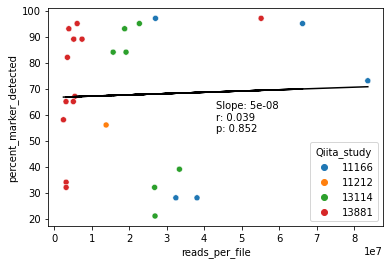

In [174]:
fig, ax1 = plt.subplots(1,1)

sns.scatterplot(data=subset_df_marker, x="reads_per_file", y="percent_marker_detected", hue = "Qiita_study", ax=ax1)
x_values = subset_df_marker["reads_per_file"]
y_values = subset_df_marker["percent_marker_detected"]
print(len(x_values))
slope, inter, r, p, stderr = linregress(x_values, y_values)
plt.plot(x_values, inter + slope*x_values,'black')
ax1.text(0.5,0.5,'Slope: ' + str(round(slope,8)) + 
         "\nr: " + str(round(r,3)) +
         "\np: " + str(round(p,3)), 
         horizontalalignment='left', 
         verticalalignment='center', 
         transform = ax1.transAxes)

plt.savefig(output_fig_dir+"reads_percent_marker_detected_"+marker_threshold+"_"+bacteria+"_"+correlation_type+"_"+str(number_of_iterations)+"repititions.png",dpi=900)
print(bacteria)

In [ ]:
    slope, _, _, _, _ = linregress(x, y)
    
    plot = sns.regplot('x',
                      'y',
                      pd.DataFrame({'x': x, 'y': y}).reset_index(),
                      scatter_kws={'alpha':0.1},
                      ax= ax1)
    plt.ylim(0, 1.0)
    plt.xlim(0, max(x)+20)

    print(("r: {r}\n"
       "p: {p}\n"
       "m: {m:8.7f}\n").format(r=r, p=p, m=slope))

/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


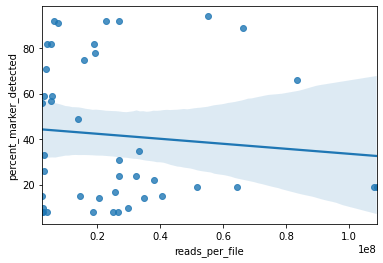

In [46]:
fig, ax1 = plt.subplots(1,1)

x_values = subset_df_marker["reads_per_file"]
y_values = subset_df_marker["percent_marker_detected"]
slope, inter, r, p, stderr = linregress(x_values, y_values)
plot = sns.regplot(x_values, y_values)
#     'x',
#                    'y',
#                     pd.DataFrame({'x': x, 'y': y}).reset_index(),
#                     scatter_kws={'alpha':0.1},
#                     ax= ax1)

# Tanglegarm visualization

In [875]:
import tanglegram as tg
import matplotlib.pyplot as plt
import pandas as pd

In [876]:
mat1 = host_patristic_dm.to_data_frame()


mat2 = sample_patristic_dm.to_data_frame()

print(type(sample_patristic_dm))
print(type(mat2))
print(mat2)

<class 'skbio.stats.distance._base.DistanceMatrix'>
<class 'pandas.core.frame.DataFrame'>
                        Trichechus_manatus  Helogale_parvula  \
Trichechus_manatus                0.000000          0.604288   
Helogale_parvula                  0.604288          0.000000   
Suricata_suricatta                0.631557          0.089644   
Mungos_mungo                      0.643597          0.101684   
Homo_sapiens                      0.615347          0.073433   
Nycticebus_pygmaeus               0.571545          0.152470   
Callosciurus_prevostii            0.572166          0.153092   

                        Suricata_suricatta  Mungos_mungo  Homo_sapiens  \
Trichechus_manatus                0.631557      0.643597      0.615347   
Helogale_parvula                  0.089644      0.101684      0.073433   
Suricata_suricatta                0.000000      0.068585      0.062594   
Mungos_mungo                      0.068585      0.000000      0.074634   
Homo_sapiens               

INFO  : Generating linkage from dataframe (tanglegram.tangle)
INFO  : Generating linkage from dataframe (tanglegram.tangle)


  0%|          | 0/1 [00:00<?, ?it/s]

INFO  : Finished optimising at entanglement 3.8333 (tanglegram.tangle)
/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/tanglegram/tangle.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=8)
/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/tanglegram/tangle.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=8)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


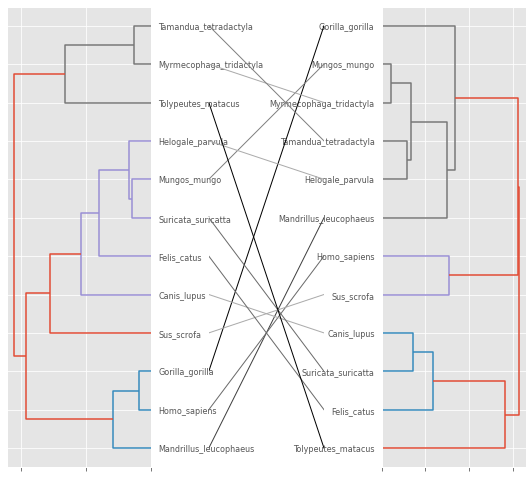

In [318]:
# Plot tanglegram
fig = tg.gen_tangle(mat1, mat2, optimize_order=True)

plt.savefig(output_fig_dir+"tanglegram_P_copri.png",dpi=900, bbox_inches="tight")
plt.show()

In [48]:
type(fig)

matplotlib.figure.Figure

INFO  : Generating linkage from dataframe (tanglegram.tangle)
INFO  : Generating linkage from dataframe (tanglegram.tangle)
/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/tanglegram/tangle.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=8)
/home/jhc103/miniconda3/envs/jupyter-general/lib/python3.6/site-packages/tanglegram/tangle.py:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=8)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


<class 'list'>
<class 'pandas.core.frame.DataFrame'>


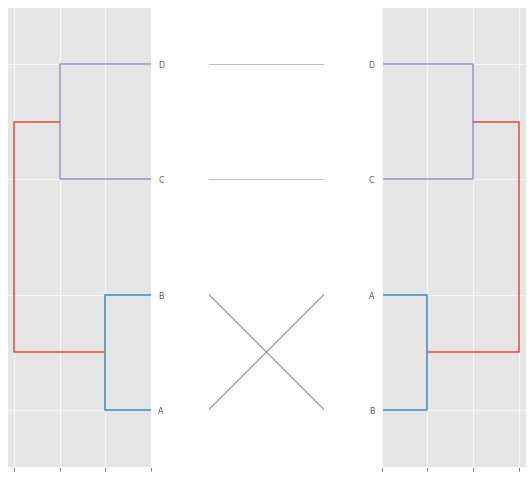

In [39]:
labelsA= ['A', 'B', 'C', 'D']
labelsB= ['B', 'A', 'C', 'D']
data = [[ 0,  .1,  .4, .3],
        [.1,   0,  .5, .6],
        [ .4, .5,   0, .2],
        [ .3, .6,  .2,  0]]

print(type(data))

mat1 = pd.DataFrame(data,
                    columns=labelsA,
                    index=labelsA)

mat2 = pd.DataFrame(data,
                    columns=labelsB,
                    index=labelsB)
print(type(mat2))

# Plot tanglegram
fig = tg.gen_tangle(mat1, mat2, optimize_order=False)
plt.show()

In [115]:
help(tg.gen_tangle)

Help on function gen_tangle in module tanglegram.tangle:

gen_tangle(a, b, labelsA=None, labelsB=None, optimize_order=10000, color_by_diff=True, link_kwargs={}, dend_kwargs={})
    Plots a tanglegram from two dendrograms.
    
    Parameters
    ----------
    (a,b) :                 pandas.DataFrame | scipy.cluster.hierarchy.linkage
                            Dendrograms to be compared. If DataFrame, will be
                            considered a distance matrix and linkage is
                            generated (see ``link_kwargs``).
    (labelsA,labelsB) :     list of str
                            If not provided and a/b are pandas Dataframes,
                            will try to extract from columns.
    optimize_order :        bool | int, optional
                            If not False, will try rearranging dendrogram to
                            optimise pairing of similar values. Currently uses
                            brute force approach -> might give varying 